# 16th april Notebook

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from IPython import display

## Creating own custom loss function

In [5]:
class myLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y):
        return torch.abs(x - y)

In [8]:
# testing loss function
loss = myLoss()
loss(torch.tensor(4), torch.tensor(5.1))

tensor(1.1000)

## Multilayer Ann Model practice

### Creating and Visualizing the data

* Naming this random data "fox"

In [16]:
# Create data
points = 300
blur = 1
a = [1, 1]
b = [5, 1]
c = [4, 4]

a = [a[0] + np.random.randn(points) * blur, a[1] + np.random.randn(points) * blur]
b = [b[0] + np.random.randn(points) * blur, b[1] + np.random.randn(points) * blur]
c = [c[0] + np.random.randn(points) * blur, c[1] + np.random.randn(points) * blur]

labels_np = np.hstack((
    np.zeros((points)),
    np.ones((points)),
    1 + np.ones((points))
))

data_np = np.hstack((a, b, c)).T
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

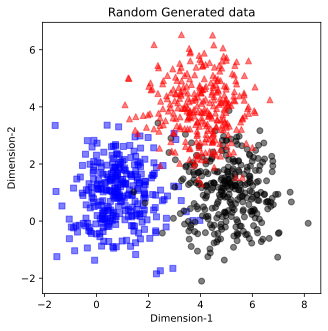

In [25]:
# Visualizing data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels==0)[0], 0],
        data[np.where(labels==0)[0], 1], "bs", alpha=0.5)
plt.plot(data[np.where(labels==1)[0], 0],
        data[np.where(labels==1)[0], 1], "ko", alpha=0.5)
plt.plot(data[np.where(labels==2)[0], 0],
        data[np.where(labels==2)[0], 1], "r^", alpha=0.5)
plt.title("Random Generated data")
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2");

### Preparing Train and Test DataLoaders

In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels,
                                                                   test_size=0.2)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

### Creating and Validating the Model

In [34]:
class foxNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input layer
        self.Input_layer = nn.Linear(2, 8)
        
        # Hidden Layers
        self.Hidden_layer_1 = nn.Linear(8, 16)
        self.Hidden_layer_2 = nn.Linear(16, 8)
        
        # Output layer
        self.Output_layer = nn.Linear(8, 3)
    
    # forward pass
    def forward(self, x):
        x = F.relu(self.Input_layer(x))
        x = F.relu(self.Hidden_layer_1(x))
        x = F.relu(self.Hidden_layer_2(x))
        return self.Output_layer(x)



def getFoxNet():
    model = foxNet()
    Loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model, Loss, optimizer

In [38]:
# Testing model with fake data
def testing():
    net, Loss, optimizer = getFoxNet()
    fake_data = torch.rand(5, 2)
    print(net(fake_data))
testing()

tensor([[-0.2787, -0.0025,  0.1239],
        [-0.2833, -0.0021,  0.1299],
        [-0.2763, -0.0011,  0.1255],
        [-0.2813, -0.0023,  0.1315],
        [-0.2807, -0.0037,  0.1307]], grad_fn=<AddmmBackward0>)


### Defining training model fuction

In [79]:
def trainFoxModel(epochs=1000):
    train_acc = []
    test_acc = []
    train_loss = []
    net, Loss, optimizer = getFoxNet()
    
    for i in range(epochs):
        net.train()
        batch_acc = []
        batch_loss = []
        for x, y in train_loader:
            # forward pass
            y_hat = net(x)
            loss = Loss(y_hat, y)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Compute acc and loss
            batch_loss.append(loss.item())
            truth = (torch.argmax(y_hat, axis=1) == y)
            truth = truth.float()
            batch_acc.append((100 * torch.mean(truth)))
        
        train_acc.append(np.mean(batch_acc))
        train_loss.append(np.mean(batch_loss))
        
        # evaluating test score
        net.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            y_hat = net(x)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
    return train_acc, train_loss, test_acc

### Training the model and visualizing the result


In [52]:
train_acc, train_loss, test_acc = trainFoxModel()

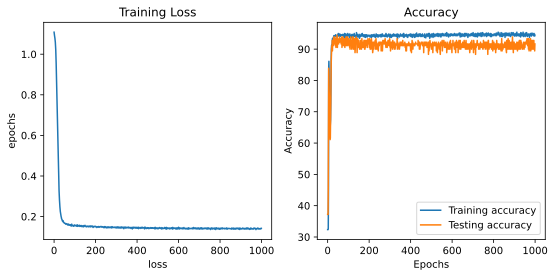

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(train_loss)
ax[0].set_xlabel("loss")
ax[0].set_ylabel("epochs")
ax[0].set_title("Training Loss")

ax[1].plot(train_acc, label="Training accuracy")
ax[1].plot(test_acc, label="Testing accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy")
ax[1].legend();

## Implmenting SGD with momentum

In [74]:
def sgdMomentum(momentum):
    class foxNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.Input_layer = nn.Linear(2, 8)

            # Hidden Layers
            self.Hidden_layer_1 = nn.Linear(8, 16)
            self.Hidden_layer_2 = nn.Linear(16, 8)

            # Output layer
            self.Output_layer = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):
            x = F.relu(self.Input_layer(x))
            x = F.relu(self.Hidden_layer_1(x))
            x = F.relu(self.Hidden_layer_2(x))
            return self.Output_layer(x)
    
    model = foxNet()
    Loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
                                momentum=momentum)
    return model, Loss, optimizer

In [75]:
def trainFoxModelMomentum(momentum=0, epochs=1000):
    train_acc = []
    test_acc = []
    train_loss = []
    net, Loss, optimizer = sgdMomentum(momentum)
    
    for i in range(epochs):
        net.train()
        batch_acc = []
        batch_loss = []
        for x, y in train_loader:
            # forward pass
            y_hat = net(x)
            loss = Loss(y_hat, y)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Compute acc and loss
            batch_loss.append(loss.item())
            truth = (torch.argmax(y_hat, axis=1) == y)
            truth = truth.float()
            batch_acc.append((100 * torch.mean(truth)))
        
        train_acc.append(np.mean(batch_acc))
        train_loss.append(np.mean(batch_loss))
        
        # evaluating test score
        net.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            y_hat = net(x)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
    return train_acc, train_loss, test_acc

In [76]:
train_acc, train_loss, test_acc = trainFoxModelMomentum(0.5)

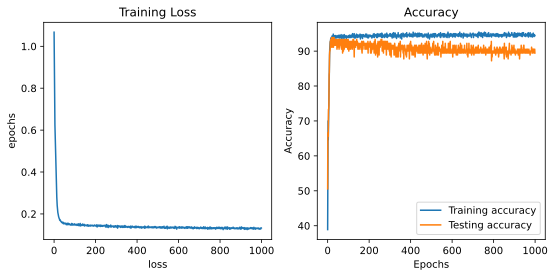

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(train_loss)
ax[0].set_xlabel("loss")
ax[0].set_ylabel("epochs")
ax[0].set_title("Training Loss")

ax[1].plot(train_acc, label="Training accuracy")
ax[1].plot(test_acc, label="Testing accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy")
ax[1].legend();

## Optimizers comparison

In [78]:
def testOptimizers(opt):
    class foxNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.Input_layer = nn.Linear(2, 8)

            # Hidden Layers
            self.Hidden_layer_1 = nn.Linear(8, 16)
            self.Hidden_layer_2 = nn.Linear(16, 8)

            # Output layer
            self.Output_layer = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):
            x = F.relu(self.Input_layer(x))
            x = F.relu(self.Hidden_layer_1(x))
            x = F.relu(self.Hidden_layer_2(x))
            return self.Output_layer(x)
    
    model = foxNet()
    Loss = nn.CrossEntropyLoss()
    
    get_opt = getattr(torch.optim, opt)
    optimizer = get_opt(model.parameters(), lr=0.01)
    return model, Loss, optimizer

In [86]:
def trainTestingModels(opt_type, epochs=100):
    train_acc = []
    test_acc = []
    train_loss = []
    net, Loss, optimizer = testOptimizers(opt_type)
    
    for i in range(epochs):
        net.train()
        batch_acc = []
        batch_loss = []
        for x, y in train_loader:
            # forward pass
            y_hat = net(x)
            loss = Loss(y_hat, y)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Compute acc and loss
            batch_loss.append(loss.item())
            truth = (torch.argmax(y_hat, axis=1) == y)
            truth = truth.float()
            batch_acc.append((100 * torch.mean(truth)))
        
        train_acc.append(np.mean(batch_acc))
        train_loss.append(np.mean(batch_loss))
        
        # evaluating test score
        net.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            y_hat = net(x)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
    return train_acc, train_loss, test_acc

In [88]:
opts = ["SGD", "Adam", "RMSprop"]
train_acc = []
train_loss = []
test_acc = []
for i in opts:
    a, b, c = trainTestingModels(i)
    train_acc.append(a)
    train_loss.append(b)
    test_acc.append(c)

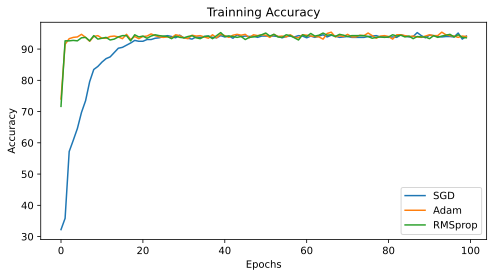

In [98]:
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.plot(train_acc[i], label=opts[i])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Trainning Accuracy")
plt.legend()
plt.show()

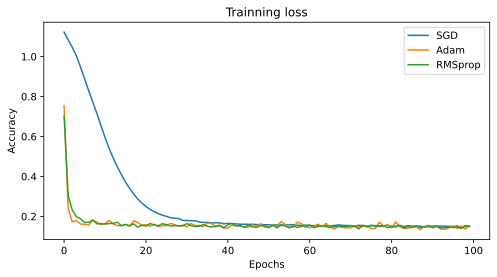

In [99]:
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.plot(train_loss[i], label=opts[i])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Trainning loss")
plt.legend()
plt.show()

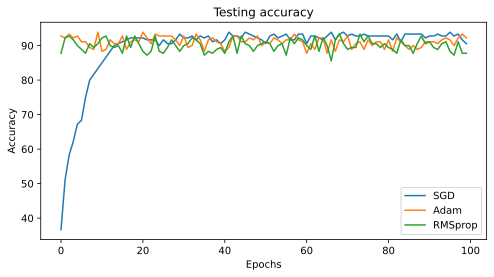

In [100]:
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.plot(test_acc[i], label=opts[i])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing accuracy")
plt.legend()
plt.show()

## FFns - Feed Forward Networks

In [125]:
data = pd.read_csv("datasets/digit-recognizer/train.csv")

In [126]:
data.shape

(42000, 785)

In [127]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
labels = data["label"]
data = data.drop("label", axis=1)

In [129]:
data = data.astype("float32") / 255.
data = data.values.reshape(-1,28,28,1)

### Visualizing images

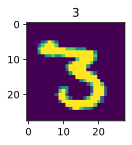

In [132]:
plt.figure(1)
plt.subplot(221)
plt.title(labels[13])
plt.imshow(data[13][:,:,0]);